<a href="https://colab.research.google.com/github/Charvee-31/Tree_classification/blob/main/treeCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os
dataset_path = "/content/drive/MyDrive/Tree_Species_Dataset/Tree_Species_Dataset"
os.listdir(dataset_path)


['bili',
 'asopalav',
 'bamboo',
 'babul',
 'banyan',
 'amla',
 'champa',
 'coconut',
 'cactus',
 'garmalo',
 'gunda',
 'gulmohor',
 'jamun',
 'kanchan',
 'kesudo',
 'khajur',
 'mango',
 'motichanoti',
 'neem',
 'nilgiri',
 'other',
 'pilikaren',
 'pipal',
 'saptaparni',
 'shirish',
 'simlo',
 'sitafal',
 'sonmahor',
 'sugarcane',
 'vad']

Preprocessing with Image Data Generator


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 1280 images belonging to 30 classes.
Found 320 images belonging to 30 classes.


Build the CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,640,222 (40.59 MB)

 Trainable params: 10,640,222 (40.59 MB)

 Non-trainable params: 0 (0.00 B)

Improving accuracy

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/tmp/ipython-input-355113885.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 839ms/step - accuracy: 0.7662 - loss: 0.8158 - val_accuracy: 0.6313 - val_loss: 1.3581
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 791ms/step - accuracy: 0.7725 - loss: 0.7810 - val_accuracy: 0.6344 - val_loss: 1.3472
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 786ms/step - accuracy: 0.7580 - loss: 0.8476 - val_accuracy: 0.6187 - val_loss: 1.3416
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 881ms/step - accuracy: 0.7726 - loss: 0.7789 - val_accuracy: 0.6313 - val_loss: 1.3363
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - accuracy: 0.7452 - loss: 0.8281 - val_accuracy: 0.6344 - val_loss: 1.3331
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 895ms/step - accuracy: 0.7594 - loss: 0.7717 - val_accuracy: 0.6250 - val_loss: 1.3273
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 782ms/step - accuracy: 0.7897 - loss: 0.7479 - val_accuracy: 0.6344 - val_loss: 1.3202
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 769ms/step - accuracy: 0.7918 - loss: 0.7212 - val_accu

Testing on new image

Taking input image from user everytime we run the cell

Saving images (1).jpeg to images (1) (6).jpeg
Saving images.jpeg to images (4).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


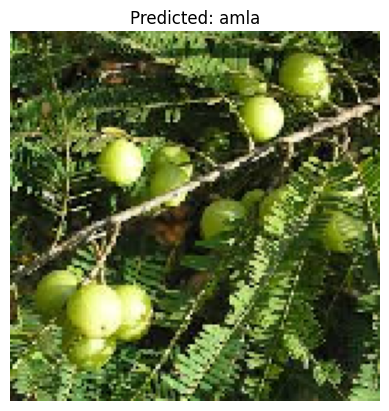

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


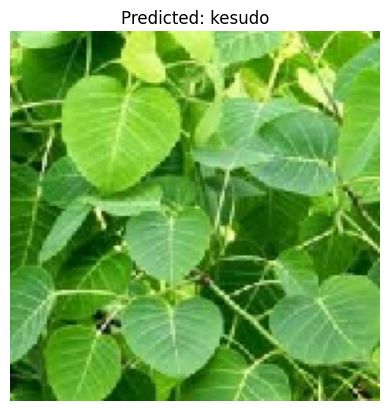

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import io
from PIL import Image

# Step 1: Upload image
uploaded = files.upload()  # this opens the file picker in Colab

# Step 2: Get filename from uploaded dictionary
for filename in uploaded.keys():
    img_path = '/content/' + filename

    # Step 3: Load and preprocess image
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # Step 4: Predict
    pred = model.predict(img_array_expanded)
    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[np.argmax(pred)]

    # Step 5: Show image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
